In [20]:
import pandas as pd
from get_milestones import main
from path import Path
import os
import time
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('./data/change_org_petitions_Amber_Heard_at_20211005-222550_limit_1000_offset_0_delay_ms_500.csv')

In [ ]:
error_slugs = set()
for slug in tqdm(df['petition__slug']):
    if not isinstance(slug, str):
        continue
    args = type('obj', (object,), {'petition_slug': slug, 'delay_ms': 100})
    with Path('./data'):
        try:
            main(args)
        except Exception as e:
            print(slug, e)
            error_slugs.add(slug)

In [9]:
# first two are not relevant
# the second one does not have public milestones
error_slugs

{'donald-j-trump-free-rapper-ynw-melly-he-is-being-framed-by-police-facing-the-death-penalty-we-have-got-to-stop-the-state-of-florida-from-killing-2-innocent-men-blacklivesmatter-alllivesmatter-freeynwmelly-freeynwbortlen',
 'sheriff-tom-bosenko-california-state-governor-california-state-senate-u-s-attorney-generl-kamala-sheriff-tom-bosenko-california-state-governor-california-state-senate-u-s-attorney-general-k-request-the-fbi-investigate-the-disappearance-of-e',
 'warner-brothers-get-johnny-depp-his-role-in-fantastic-beasts-back-arrest-fire-amber-heard-from-aquaman-2'}

In [10]:
# merging everything into a single dataframe

In [14]:
l = os.listdir('./data')
fs = []
for filename in l:
    if not(filename.startswith('change_org_milestones_petition_slug_') and filename.endswith('.csv')):
        continue
    fs.append('./data/' + filename)

In [90]:
def read_set_slug(f):
    df = pd.read_csv(f)
    ff = os.path.basename(f)
    slug = ff[len('change_org_milestones_petition_slug_'):ff.index('_at_')]
    df['petition__slug'] = [slug] * len(df)
    return df

In [108]:
df = pd.concat([read_set_slug(f) for f in tqdm(fs)])
df = df.reset_index()

df_status = pd.read_csv('./data/all_petitions_status_manual.csv')
def get_status(slug):
    return df_status[df_status['slug'] == slug].iloc[0].status
df['status_manual'] = [get_status(t) for t in df.petition__slug]
df = df[df['status_manual'] != 'irrelevant']

  0%|          | 0/286 [00:00<?, ?it/s]

In [109]:
df.to_csv(f"./data/all_petitions_milestones_{time.strftime('%Y%m%d-%H%M%S')}.csv", index=False)

# Optional: plotting all timelines

In [110]:
from matplotlib import pyplot as plt

In [111]:
df_ = df[df['__typename'] == 'MilestonePetitionUpdate'].copy()

In [112]:
df_['createdAt'] = pd.to_datetime(df_.createdAt)

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

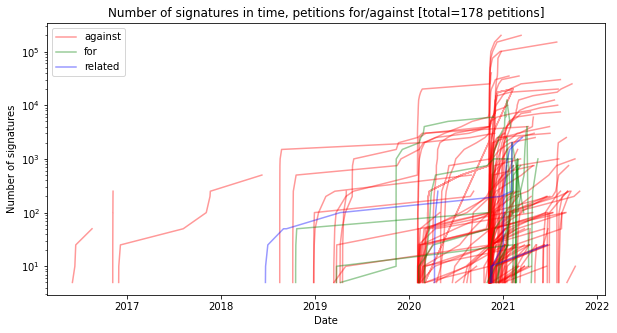

In [128]:
colors = {'for': 'green', 'against': 'red', 'related': 'blue'}
plt.figure(figsize=(10, 5))
plt.title('Number of signatures in time, petitions for/against [total=%d petitions]' % len(set(df_.petition__slug)))
for status, group_status in df_.groupby('status_manual'):
    i = 0
    for petition__slug, group in tqdm(group_status.groupby('petition__slug')):
        kwargs = {}
        if i == 0:
            kwargs['label'] = status
        plt.plot(group.createdAt, group.signatureCount, color=colors[status], alpha=0.4, **kwargs)
        i += 1
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Number of signatures')
plt.legend()
plt.savefig('./figures/petitions_signatures_in_time.png', bbox_inches='tight')
plt.show()

In [118]:
len(df_)

1548